Set up environment

In [3]:
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from google.colab import drive
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Load preprocessed data

In [4]:
drive.mount('/content/drive')

#Define dataset path
zip_path = "/content/drive/MyDrive/augmented_images_balance.zip"
extract_path = "/content/augmented_images_balance"

#Extract
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")



Mounted at /content/drive
Dataset extracted successfully!


In [5]:
IMG_SIZE = (224, 224)  #ResNet50 expects 224x224 images
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

#Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(extract_path, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(extract_path, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(extract_path, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

print("Dataset successfully loaded!")


Found 18124 files belonging to 2 classes.
Found 1502 files belonging to 2 classes.
Found 1503 files belonging to 2 classes.
Dataset successfully loaded!


Construct model

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

#Load Pretrained ResNet50 (excluding top layers) and freeze its weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#custom classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

#Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train model with the custom class weights to address class imabalance and ensure consistency across models

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

In [ ]:
class_weights = {0: np.float64(0.8030840127614322), 1: np.float64(1.3248538011695907)}

EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights  #Apply custom class weights here
)

#Evaluate the Model on Test Data & Save Weights

test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")

model.save_weights("/content/drive/MyDrive/resnet50_model.weights.h5")
print("Model saved successfully!")

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.7508 - loss: 0.5012 - val_accuracy: 0.7763 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7866 - loss: 0.4106 - val_accuracy: 0.8083 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8003 - loss: 0.3862 - val_accuracy: 0.8162 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8105 - loss: 0.3734 - val_accuracy: 0.8296 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8179 - loss: 0.3570 - val_accuracy: 0.8049 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8318 - loss: 0.3397 - val_accuracy: 0.8256 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8374 - l

Test metrics

In [7]:
#Load the model weights and compute the test loss
model.load_weights("/content/drive/MyDrive/resnet50_model.weights.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"\nTest Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.8261 - loss: 0.3523

Test Loss: 0.3504

Test Accuracy: 0.8370


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

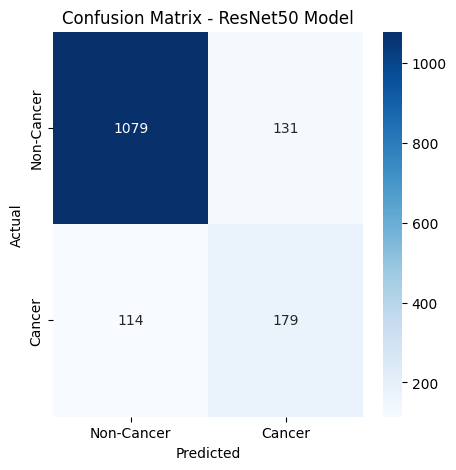

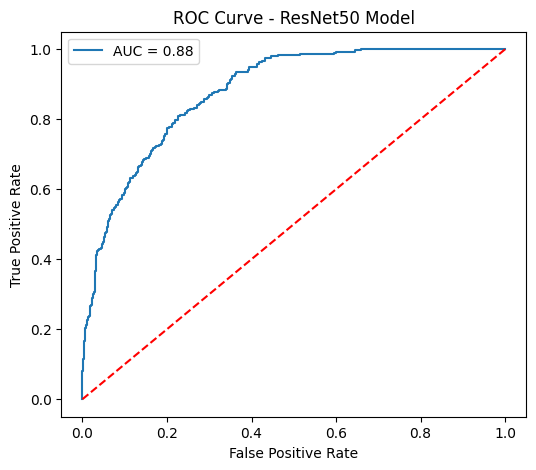

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_fscore_support


y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    preds = model.predict(images).ravel()
    y_pred_probs.extend(preds)
    y_true.extend(labels.numpy())

y_pred = np.round(y_pred_probs)  #Convert probabilities to binary predictions

#evaluation metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

#confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Cancer", "Cancer"],
            yticklabels=["Non-Cancer", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50 Model")
plt.show()

#ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Baseline for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 Model")
plt.legend()
plt.show()

In [ ]:
#Predictions
y_pred_prob = model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype("int32")

#Get true labels from the test dataset using a loop
y_true = []
for _, labels in test_dataset:  # Iterate through the dataset
    y_true.extend(labels.numpy())  # Extract and store true labels

#Reports
print("Classification Report:\n", classification_report(y_true, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.79      1210
         1.0       0.18      0.19      0.18       293

    accuracy                           0.67      1503
   macro avg       0.49      0.49      0.49      1503
weighted avg       0.68      0.67      0.68      1503



In [ ]:
#Threshold analyses
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    y_pred_t = (np.array(y_pred_probs) > t).astype("int32")
    p, r, f1_val, _ = precision_recall_fscore_support(y_true, y_pred_t, average='binary')
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1_val:.2f}")

Threshold: 0.10 | Precision: 0.19 | Recall: 0.44 | F1: 0.26
Threshold: 0.15 | Precision: 0.19 | Recall: 0.40 | F1: 0.25
Threshold: 0.20 | Precision: 0.18 | Recall: 0.37 | F1: 0.24
Threshold: 0.25 | Precision: 0.19 | Recall: 0.35 | F1: 0.25
Threshold: 0.30 | Precision: 0.19 | Recall: 0.32 | F1: 0.24
Threshold: 0.35 | Precision: 0.19 | Recall: 0.28 | F1: 0.23
Threshold: 0.40 | Precision: 0.18 | Recall: 0.24 | F1: 0.21
Threshold: 0.45 | Precision: 0.17 | Recall: 0.21 | F1: 0.19
Threshold: 0.50 | Precision: 0.18 | Recall: 0.19 | F1: 0.19
Threshold: 0.55 | Precision: 0.19 | Recall: 0.18 | F1: 0.19
Threshold: 0.60 | Precision: 0.20 | Recall: 0.15 | F1: 0.17
Threshold: 0.65 | Precision: 0.20 | Recall: 0.13 | F1: 0.16
Threshold: 0.70 | Precision: 0.20 | Recall: 0.10 | F1: 0.13
Threshold: 0.75 | Precision: 0.21 | Recall: 0.09 | F1: 0.12
Threshold: 0.80 | Precision: 0.21 | Recall: 0.07 | F1: 0.10
Threshold: 0.85 | Precision: 0.17 | Recall: 0.04 | F1: 0.07
